## 🧩 1. Import Required Libraries

In [10]:
# Import essential libraries for data manipulation, image processing, and ML
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

## 📁 2. Load and Filter Dataset

In [11]:
# Define paths to metadata and image directory
metadata_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv'
images_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images'

# Load CSV and filter relevant columns, removing rows with missing values
df = pd.read_csv(metadata_path, on_bad_lines='skip')
df = df.dropna(subset=['id', 'articleType', 'baseColour', 'gender'])

# Limit to a smaller dataset for faster testing
df = df.head(5000)

# Add image filename and filepath columns
df['filename'] = df['id'].astype(str) + '.jpg'
df['filepath'] = df['filename'].apply(lambda x: os.path.join(images_path, x))

# Filter only existing images
df['exists'] = df['filepath'].apply(os.path.exists)
print("✅ Number of existing images found:", df['exists'].sum())

# Keep only valid images
df = df[df['exists']].reset_index(drop=True)

✅ Number of existing images found: 5000


## 🧠 3. Prepare Feature Extraction Model (MobileNetV2)

In [12]:
# Prepare a MobileNetV2 model without pre-trained weights and without the top classifier
input_tensor = Input(shape=(224, 224, 3))
base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights=None)
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)

print("✅ Feature extraction model is ready (MobileNetV2 without weights).")

✅ Feature extraction model is ready (MobileNetV2 without weights).


## 🧪 4. Extract Visual Features from Images

In [13]:
def extract_features(filepaths):
    """
    Extract features from image files using MobileNetV2.
    Returns a numpy array of image embeddings.
    """
    features = []
    for path in tqdm(filepaths, desc='Extracting visual features'):
        try:
            img = image.load_img(path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            feat = model.predict(x, verbose=0)
            features.append(feat.flatten())
        except Exception as e:
            print(f"⚠️ Error reading {path}: {e}")
            features.append(np.zeros(1280))  # Fallback zero vector
    return np.array(features)

# Run feature extraction
features_array = extract_features(df['filepath'])
print("✅ Visual features extracted. Shape:", features_array.shape)

# Save to dataframe
df['features'] = list(features_array)

Extracting visual features:   0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_155']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
Extracting visual features: 100%|██████████| 5000/5000 [14:13<00:00,  5.85it/s]

✅ Visual features extracted. Shape: (5000, 1280)


## 🧾 5. Encode Textual Metadata

In [15]:
# Convert text features into numeric form
text_features = df[['articleType', 'baseColour', 'gender']].astype(str)

# Apply Label Encoding to each categorical column
for col in text_features.columns:
    le = LabelEncoder()
    text_features[col] = le.fit_transform(text_features[col])

df['text_vector'] = list(text_features.values)
print("✅ Textual metadata encoded.")

✅ Textual metadata encoded.


## 🔗 6. Combine Visual and Textual Features

In [16]:
# Combine image features with encoded text data
combined_features = []
for i in range(len(df)):
    visual = df.iloc[i]['features']
    text = df.iloc[i]['text_vector']
    combined = np.concatenate((visual, text))
    combined_features.append(combined)

combined_features = np.array(combined_features)
print("✅ Combined features shape:", combined_features.shape)

✅ Combined features shape: (5000, 1283)


## 📐 7. Compute Cosine Similarity Between Products

In [17]:
# Compute similarity scores for all products
similarity = cosine_similarity(combined_features)
print("✅ Cosine similarity matrix computed.")

✅ Cosine similarity matrix computed.


## 🖼️ 8. Define Function to Visualize Similar Items

In [18]:
def show_similar(index, top_n=5):
    """
    Show the most similar items to a given product index.
    """
    print(f"\n🔍 Query Product: {df.iloc[index]['articleType']} - {df.iloc[index]['baseColour']}")
    
    query_path = df.iloc[index]['filepath']
    
    # Plot original image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, top_n + 1, 1)
    img = cv2.imread(query_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Query Image")
    plt.axis('off')

    # Find top-N most similar items
    scores = list(enumerate(similarity[index]))
    top_similar = sorted(scores, key=lambda x: x[1], reverse=True)[1:top_n + 1]

    # Display similar images
    for i, (idx, score) in enumerate(top_similar):
        sim_img = cv2.imread(df.iloc[idx]['filepath'])
        plt.subplot(1, top_n + 1, i + 2)
        plt.imshow(cv2.cvtColor(sim_img, cv2.COLOR_BGR2RGB))
        title = f"{df.iloc[idx]['articleType']} ({score:.2f})"
        plt.title(title, fontsize=9)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## 🧪 9. Try the Recommendation System


🔍 Query Product: Casual Shoes - Black


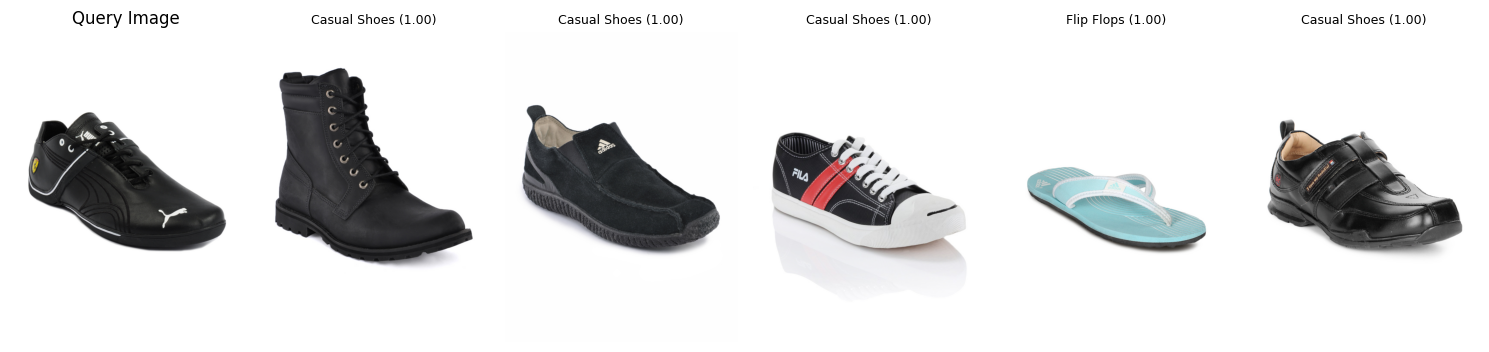


🔍 Query Product: Shorts - Black


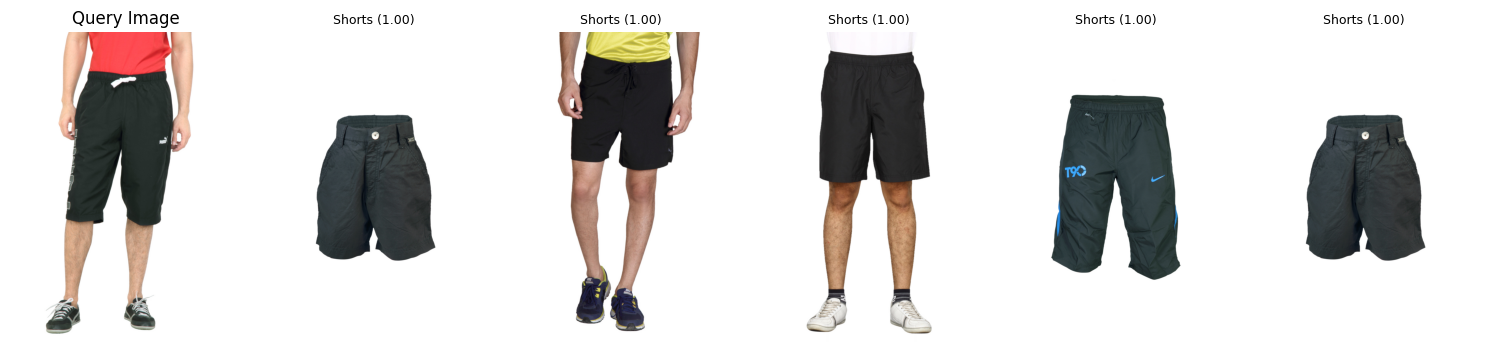


🔍 Query Product: Watches - Black


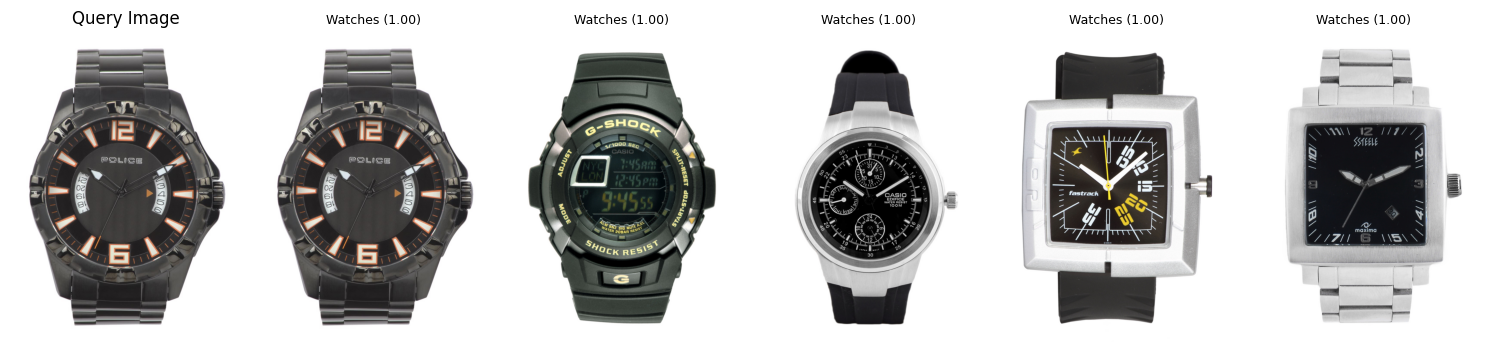


🔍 Query Product: Heels - Black


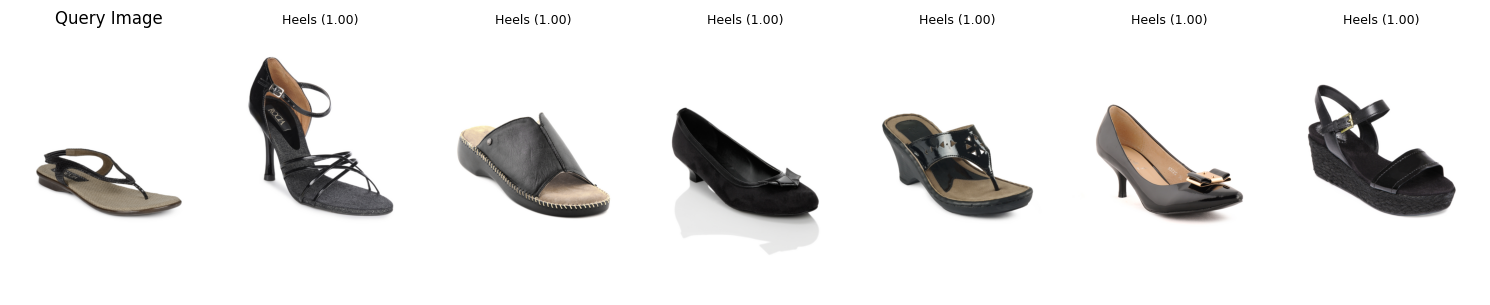


🔍 Query Product: Tshirts - Black


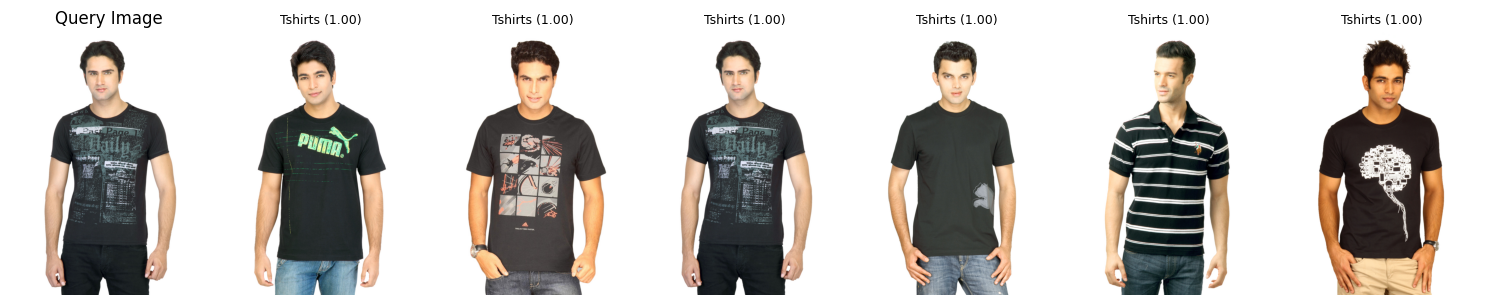


🔍 Query Product: Handbags - Brown


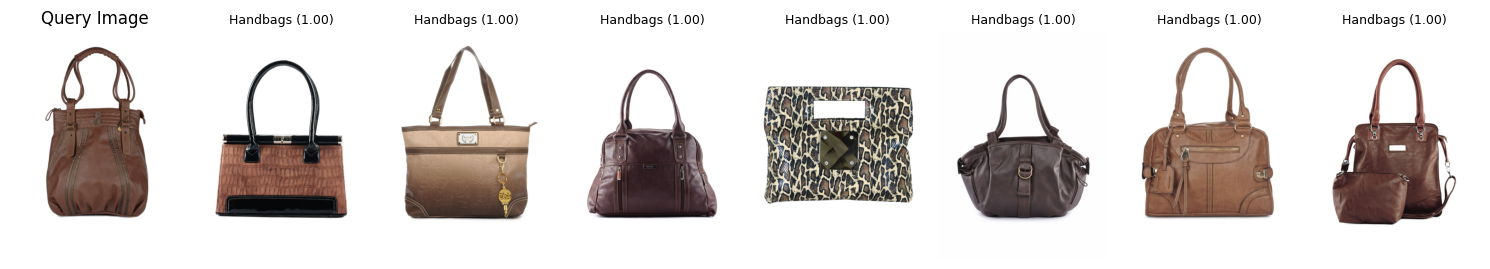


🔍 Query Product: Tshirts - Navy Blue


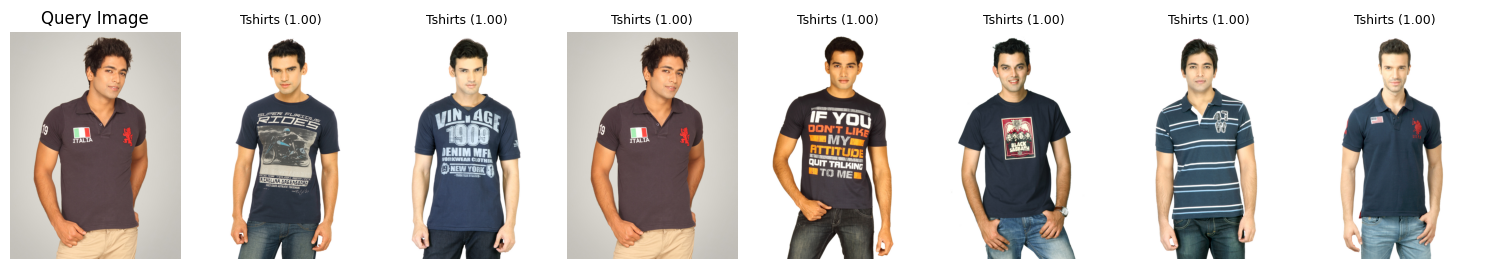

In [19]:
# Show recommendations for several random products
show_similar(index=10, top_n=5)
show_similar(index=46, top_n=5)
show_similar(index=16, top_n=5)
show_similar(index=76, top_n=6)
show_similar(index=98, top_n=6)
show_similar(index=19, top_n=7)
show_similar(index=199, top_n=7)